# Electricity Load Forecasting with Random Forest
This notebook builds and evaluates a multi-horizon Random Forest model to forecast electricity load up to 24 hours ahead.
It includes data preparation, hyperparameter tuning with TimeSeriesSplit and final testing on unseen data.
Results are analyzed through error metrics, feature importance, and SHAP explanations to ensure interpretability and robustness.

## Imports

In [3]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
import os
import shap
import joblib
import seaborn as sns

## Loading the Data

In [2]:
# Define the Paths for loading the data
interim_folder = "../data/processed"

# Load the CSV with the data for all years
train_val_df = pd.read_csv(os.path.join(interim_folder, "train_val_df.csv"), sep=';', decimal=',')
test_df = pd.read_csv(os.path.join(interim_folder, "test_df.csv"), sep=';', decimal=',')

In [3]:
# Take a quick look at the training data
train_val_df.head(1)

,timestamp,load_MWh,lag_1,lag_2,lag_3,lag_6,lag_24,lag_168,lag_336,lag_672,lag_8760,hour,weekday,is_weekend
0,2022-01-01 01:00:00,41535.75,43915.5,45616.75,47461.5,55785.75,43679.5,41509.0,49242.25,54252.25,44569.25,1,5,1


In [4]:
# Take a quick look at the test data
test_df.head(1)

,timestamp,load_MWh,lag_1,lag_2,lag_3,lag_6,lag_24,lag_168,lag_336,lag_672,lag_8760,hour,weekday,is_weekend
0,2024-01-01 00:00:00,40170.25,42140.0,44088.5,45158.75,52607.25,38361.75,40748.0,47626.0,49797.5,40646.5,0,0,0


## Data Preparation

In [5]:
# Convert timestamp to datetime
train_val_df["timestamp"] = pd.to_datetime(train_val_df["timestamp"])
test_df["timestamp"] = pd.to_datetime(test_df["timestamp"])

In [6]:
# Define the features and targets
feature_cols = [c for c in train_val_df.columns if c not in ["timestamp", "load_MWh"]]
target_col = "load_MWh"

X_trainval = train_val_df[feature_cols]
y_trainval = train_val_df[target_col]

X_test = test_df[feature_cols]
y_test = test_df[target_col]

print(f"Train/Val samples: {X_trainval.shape[0]}, Test samples: {X_test.shape[0]}")
print(f"Feature count: {len(feature_cols)}")

Train/Val samples: 17517, Test samples: 8783
Feature count: 12


In [7]:
train_val_df["load_MWh"].describe()

count    17517.000000
mean     53694.217503
std       9460.250499
min      30902.750000
25%      45940.500000
50%      53714.000000
75%      60986.250000
max      78680.500000
Name: load_MWh, dtype: float64

## Building the Random Forest Models

### 1. Grid Search

This section performs hyperparameter tuning for 24 separate Random Forest models, each predicting a specific forecast horizon (1–24 hours ahead).
Using TimeSeriesSplit cross-validation, the code tests multiple parameter combinations and selects the one minimizing the Root Mean Squared Error (RMSE) for each horizon.
After identifying the best parameters, a final model is trained and stored per forecast step.

In [8]:
# Define the parameter grid
param_grid = {
    "n_estimators": [200, 400],
    "max_depth": [10, 20, None],
    "min_samples_split": [2, 5],
    "min_samples_leaf": [1, 3],
    "max_features": ["sqrt", "log2"]
}

# Initialize time series cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Dictionaries to store results
best_params_24h = {}
best_rmse_24h = {}

for h in range(1, 25):
    print(f"Running Grid Search for {h}-hour-ahead model...")

    # Shift target by h hours into the future
    y_shifted = y_trainval.shift(-h)
    valid_idx = y_shifted.notna()

    X_train_h = X_trainval.loc[valid_idx]
    y_train_h = y_shifted.loc[valid_idx]

    rf = RandomForestRegressor(random_state=42, n_jobs=-1)

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        scoring="neg_root_mean_squared_error",
        cv=tscv,
        n_jobs=-1,
        verbose=0
    )

    grid_search.fit(X_train_h, y_train_h)

    best_params_24h[h] = grid_search.best_params_
    best_rmse_24h[h] = -grid_search.best_score_

print("Finished grid search for 24 horizons.")
print(f"Average CV RMSE across all horizons: {np.mean(list(best_rmse_24h.values())):.2f}")

Running Grid Search for 1-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 2-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 3-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 4-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 5-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 6-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 7-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 8-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 9-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 10-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 11-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 12-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 13-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 14-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 15-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 16-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 17-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 18-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 19-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 20-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 21-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 22-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 23-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Running Grid Search for 24-hour-ahead model...


/Users/sandragedig/Documents/Dokumente/Data_Science/Bachelorarbeit/STLF_Germany/stlf_germany/venv/lib/python3.9/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Finished grid search for 24 horizons.
Average CV RMSE across all horizons: 2921.99


In [9]:
# Save Grid Search results
grid_results_dir = "../models/RF/grid_search_results"
os.makedirs(grid_results_dir, exist_ok=True)

# Save best parameters and CV scores
joblib.dump(best_params_24h, os.path.join(grid_results_dir, "best_params_24h.joblib"))
joblib.dump(best_rmse_24h, os.path.join(grid_results_dir, "best_rmse_24h.joblib"))

# Save readable CSV summary
summary_df = pd.DataFrame([
    {"horizon": h, **best_params_24h[h], "cv_rmse": best_rmse_24h[h]}
    for h in sorted(best_params_24h.keys())
])

summary_df.to_csv(
    os.path.join(grid_results_dir, "grid_search_summary.csv"),
    index=False
)

print(f"Saved grid search results to: {grid_results_dir}")

Saved grid search results to: ../models/RF/grid_search_results


In [4]:
grid_results_dir = "../models/RF/grid_search_results"

best_params_24h = joblib.load(
    os.path.join(grid_results_dir, "best_params_24h.joblib")
)

best_rmse_24h = joblib.load(
    os.path.join(grid_results_dir, "best_rmse_24h.joblib")
)

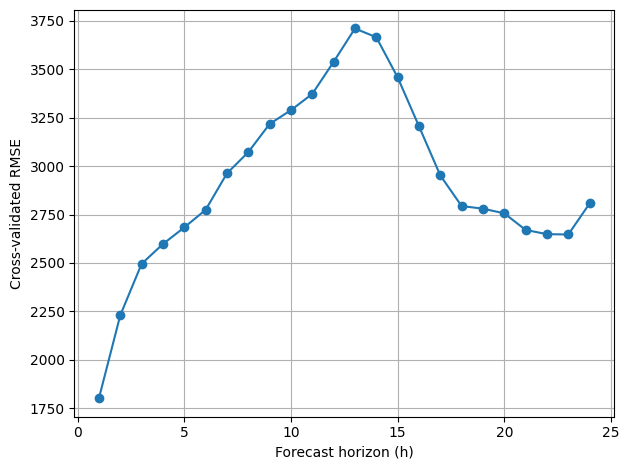

In [7]:
summary_df = pd.read_csv(
    os.path.join(grid_results_dir, "grid_search_summary.csv")
)

summary_df

# Plot RMSE curve per horizon
plt.figure()
plt.plot(summary_df["horizon"], summary_df["cv_rmse"], marker="o")
plt.xlabel("Forecast horizon (h)")
plt.ylabel("Cross-validated RMSE")
plt.grid(True)
plt.tight_layout()
plt.show()

**Key Findings – Grid Search Results**

- The optimal **Random Forest configurations** are largely consistent across horizons, indicating model stability.  
- Most horizons prefer **`max_features='sqrt'`**, **`min_samples_split=2`**, and **`min_samples_leaf=1`**, showing that deeper, flexible trees yield the best accuracy.  
- The parameter **`max_depth`** alternates between `20` and `None`, suggesting that some horizons benefit from full tree depth, while others achieve slightly better generalization with constrained depth.  
- **`n_estimators`** values of 200 and 400 dominate, reflecting a trade-off between performance and computational cost.  
- The **best RMSE** values gradually increase with forecast horizon — from around **1.8 GWh** for short-term predictions (1 hour ahead) to about **3.7 GWh** for longer horizons — confirming the expected loss of precision as the forecast window extends.  
- Overall, the tuning results highlight a **robust and consistent Random Forest setup** capable of maintaining good accuracy across all 24 prediction steps.  


### 2. Final Model Training

In this step, a separate Random Forest model is trained for each forecast horizon (1–24 hours ahead) using the previously optimized hyperparameters.
By training 24 individual models, each one specializes in predicting a specific time step into the future, rather than relying on a single generic model.
This approach improves forecast accuracy and stability, as each model can adapt to the distinct temporal dynamics and feature relationships relevant to its prediction horizon.

In [11]:
# Train one Random Forest model for each forecast horizon (1–24 hours ahead)
models_24h = {}  # dictionary to store models for each hour
horizon = 24

for h in range(1, horizon + 1):
    print(f"Training model for hour {h} ahead...")

    # Shift the target by 'h' steps to create a horizon-specific target
    y_shifted = y_trainval.shift(-h)

    # Remove rows with NaN values caused by the shift
    valid_idx = y_shifted.notna()
    X_train_h = X_trainval.loc[valid_idx]
    y_train_h = y_shifted.loc[valid_idx]

    # Train the model using the best hyperparameters for this horizon
    model = RandomForestRegressor(random_state=42, **best_params_24h[h])
    model.fit(X_train_h, y_train_h)

    # Save the trained model for this forecast horizon
    models_24h[h] = model

print("Trained and stored 24 separate Random Forest models (1–24 hours ahead).")


Training model for hour 1 ahead...
Training model for hour 2 ahead...
Training model for hour 3 ahead...
Training model for hour 4 ahead...
Training model for hour 5 ahead...
Training model for hour 6 ahead...
Training model for hour 7 ahead...
Training model for hour 8 ahead...
Training model for hour 9 ahead...
Training model for hour 10 ahead...
Training model for hour 11 ahead...
Training model for hour 12 ahead...
Training model for hour 13 ahead...
Training model for hour 14 ahead...
Training model for hour 15 ahead...
Training model for hour 16 ahead...
Training model for hour 17 ahead...
Training model for hour 18 ahead...
Training model for hour 19 ahead...
Training model for hour 20 ahead...
Training model for hour 21 ahead...
Training model for hour 22 ahead...
Training model for hour 23 ahead...
Training model for hour 24 ahead...
Trained and stored 24 separate Random Forest models (1–24 hours ahead).


In [12]:
# Save the trained models
# Define model save path
model_dir = "../models/RF"
os.makedirs(model_dir, exist_ok=True)

# Save each trained model
for h, model in models_24h.items():
    model_path = os.path.join(model_dir, f"rf_model_h{h}.joblib")
    joblib.dump(model, model_path)
    print(f"Saved model for hour {h} → {model_path}")

print(f"All 24 Random Forest models successfully saved to: {model_dir}")

Saved model for hour 1 → ../models/RF/rf_model_h1.joblib
Saved model for hour 2 → ../models/RF/rf_model_h2.joblib
Saved model for hour 3 → ../models/RF/rf_model_h3.joblib
Saved model for hour 4 → ../models/RF/rf_model_h4.joblib
Saved model for hour 5 → ../models/RF/rf_model_h5.joblib
Saved model for hour 6 → ../models/RF/rf_model_h6.joblib
Saved model for hour 7 → ../models/RF/rf_model_h7.joblib
Saved model for hour 8 → ../models/RF/rf_model_h8.joblib
Saved model for hour 9 → ../models/RF/rf_model_h9.joblib
Saved model for hour 10 → ../models/RF/rf_model_h10.joblib
Saved model for hour 11 → ../models/RF/rf_model_h11.joblib
Saved model for hour 12 → ../models/RF/rf_model_h12.joblib
Saved model for hour 13 → ../models/RF/rf_model_h13.joblib
Saved model for hour 14 → ../models/RF/rf_model_h14.joblib
Saved model for hour 15 → ../models/RF/rf_model_h15.joblib
Saved model for hour 16 → ../models/RF/rf_model_h16.joblib
Saved model for hour 17 → ../models/RF/rf_model_h17.joblib
Saved model for

### 3. Testing on Future Data

This step evaluates the 24 trained Random Forest models on the unseen test dataset.
Each model is responsible for predicting a specific forecast horizon (1–24 hours ahead), enabling a full-day load forecast.
By applying the models to new, unseen data, the function measures how well the models generalize beyond the training period.
Performance is assessed using RMSE and MAPE per forecast step and overall, while forecast errors are recorded per horizon for detailed error distribution analysis.

In [ ]:
def multi_model_24h_forecast(models_24h, X_test, y_test, horizon=24, step=24, eps=1e-6):
    """
    Direct multi-horizon forecasting with 24 separate models (1..24 hours ahead).

    Definition:
      - Forecast origin is time t (row index = start)
      - Model h predicts target at t+h
      - Therefore, the truth block is y[t+1] .. y[t+24]

    Evaluation can be done with:
      - step=24 (non-overlapping daily origins) or
      - step=1  (hourly origins, overlapping)

    Returns:
      - all_preds, all_truth (flattened, length = n_windows * horizon)
      - rmse_per_horizon (length = horizon)
      - mape_per_horizon (length = horizon)
      - errors_by_horizon (dict: h -> list of errors)
    """
    all_preds = []
    all_truth = []
    errors_by_horizon = {h: [] for h in range(1, horizon + 1)}

    sse_per_h = np.zeros(horizon)  # sum of squared errors per horizon
    ape_per_h = np.zeros(horizon)  # sum of abs percentage errors per horizon
    n_windows = 0

    y_test_values = np.asarray(y_test)

    # need y_block = y[start+1 : start+1+horizon], so start must allow start+1+horizon <= len(y)
    for start in range(0, len(X_test) - (horizon + 1) + 1, step):
        X_origin = X_test.iloc[[start]]  # features at time t
        y_block = y_test_values[start + 1 : start + 1 + horizon]  # truth: t+1 .. t+24

        preds_24h = np.zeros(horizon)

        for h in range(1, horizon + 1):
            model = models_24h[h]
            yhat = model.predict(X_origin)[0]
            preds_24h[h - 1] = yhat

            err = y_block[h - 1] - yhat
            errors_by_horizon[h].append(err)

        errs = y_block - preds_24h
        sse_per_h += errs ** 2
        ape_per_h += np.abs(errs) / np.clip(np.abs(y_block), eps, None) * 100

        all_preds.extend(preds_24h.tolist())
        all_truth.extend(y_block.tolist())
        n_windows += 1

    rmse_per_horizon = np.sqrt(sse_per_h / n_windows)
    mape_per_horizon = ape_per_h / n_windows

    total_rmse = np.sqrt(mean_squared_error(all_truth, all_preds))
    total_mape = np.mean(
        np.abs((np.array(all_truth) - np.array(all_preds)) / np.clip(np.abs(np.array(all_truth)), eps, None))
    ) * 100

    print(f"Overall RMSE: {total_rmse:.2f}")
    print(f"Overall MAPE: {total_mape:.2f}%")

    return (
        np.array(all_preds),
        np.array(all_truth),
        rmse_per_horizon,
        mape_per_horizon,
        errors_by_horizon
    )


horizon = 24
step = 24

preds, truth, mean_rmse_h, mean_mape_h, errors_by_horizon = multi_model_24h_forecast(
    models_24h=models_24h,
    X_test=X_test,
    y_test=y_test,
    horizon=horizon,
    step=step
)

# create matching timestamps for truth/preds (t+1 .. t+24 for each origin t)
origin_idx = list(range(0, len(test_df) - (horizon + 1) + 1, step))

timestamps = []
for start in origin_idx:
    timestamps.extend(test_df["timestamp"].iloc[start + 1 : start + 1 + horizon].tolist())

results_df = pd.DataFrame({
    "timestamp": timestamps,
    "Actual_Load_MWh": truth,
    "Predicted_Load_MWh": preds
})

Overall RMSE: 2363.02
Overall MAPE: 3.02%


## Visualization of the Model Performance

### 1. Daily Average Electricity Load: Actual vs Predicted
This section compares the predicted and actual electricity load on the test dataset.
Hourly predictions are aggregated to daily averages to visualize overall forecast accuracy and capture long-term trends.
The plot illustrates how closely the Random Forest models reproduce real load patterns throughout the test year, providing an intuitive check of model performance and temporal consistency.

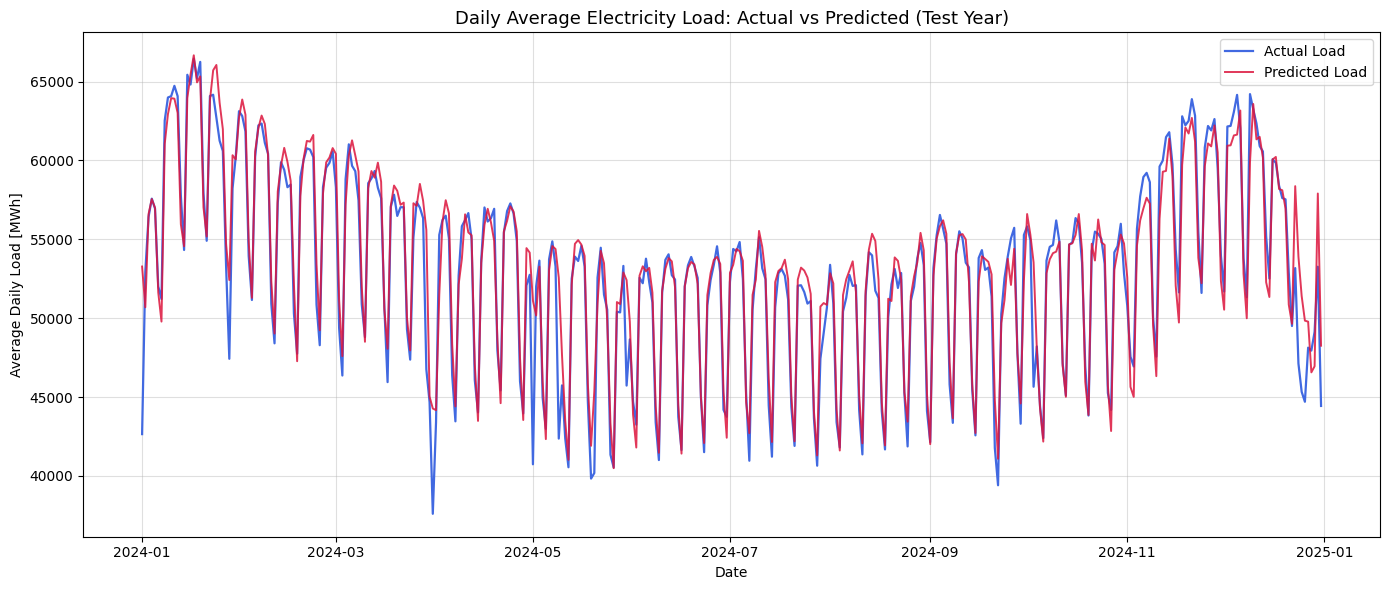

In [15]:
# Convert timestamp and aggregate daily means
results_df["timestamp"] = pd.to_datetime(results_df["timestamp"])
daily_df = results_df.resample("D", on="timestamp").mean()

# Plot daily aggregated actual vs predicted load
plt.figure(figsize=(14,6))
plt.plot(daily_df.index, daily_df["Actual_Load_MWh"], label="Actual Load", color="royalblue", linewidth=1.6)
plt.plot(daily_df.index, daily_df["Predicted_Load_MWh"], label="Predicted Load", color="crimson", linewidth=1.4, alpha=0.85)
plt.title("Daily Average Electricity Load: Actual vs Predicted (Test Year)", fontsize=13)
plt.xlabel("Date")
plt.ylabel("Average Daily Load [MWh]")
plt.legend()
plt.grid(True, alpha=0.4)
plt.tight_layout()
plt.show()


**Key Findings – Actual vs Predicted Daily Load**

- The predicted load curve closely follows the actual daily load, demonstrating that the Random Forest models **generalize well** to unseen test data.  
- Both **seasonal** and **daily consumption patterns** are captured accurately, including the winter peaks and the lower summer demand.  
- Minor deviations appear during periods of rapid load fluctuations, indicating slightly reduced sensitivity to sudden changes.  
- Overall, the results confirm that the model effectively learns the underlying **seasonal and cyclical behavior** of electricity consumption while maintaining high predictive accuracy across the test year.  

### 2. Average RMSE & MAPE per Forecast Step
This section visualizes the average RMSE and MAPE for all 24 forecast horizons to assess how prediction accuracy changes with the forecast step.
The plots reveal how errors evolve as the model predicts further into the future, providing insight into short-term vs. long-term forecast reliability.
Together, they highlight the model’s ability to maintain stable performance while quantifying the gradual increase in uncertainty typical of multi-step forecasting.

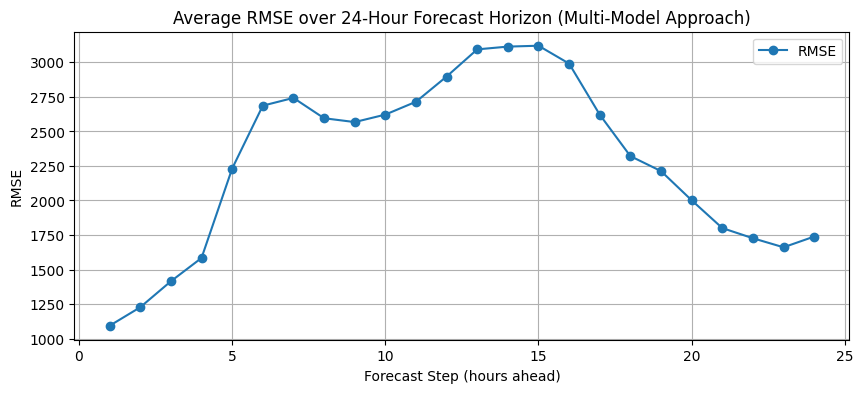

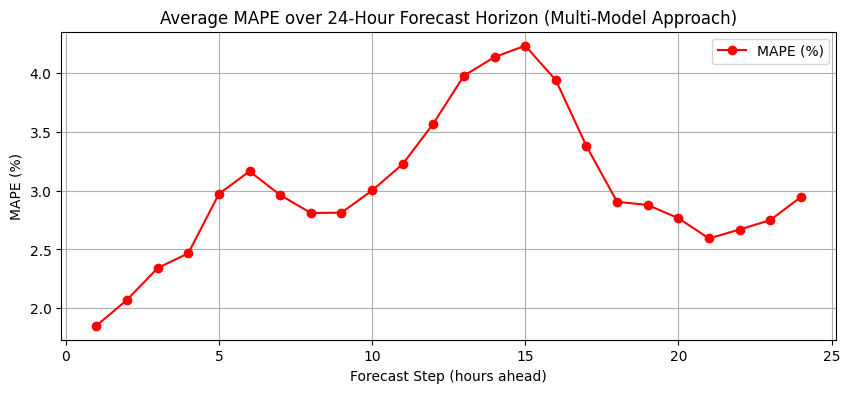

In [16]:
# Plot Average RMSE over 24 forecast steps
plt.figure(figsize=(10,4))
plt.plot(range(1, 25), mean_rmse_h, marker='o', label='RMSE')
plt.title("Average RMSE over 24-Hour Forecast Horizon (Multi-Model Approach)")
plt.xlabel("Forecast Step (hours ahead)")
plt.ylabel("RMSE")
plt.grid(True)
plt.legend()
plt.show()

# Plot Average MAPE over 24 forecast steps
plt.figure(figsize=(10,4))
plt.plot(range(1, 25), mean_mape_h, color='red', marker='o', label='MAPE (%)')
plt.title("Average MAPE over 24-Hour Forecast Horizon (Multi-Model Approach)")
plt.xlabel("Forecast Step (hours ahead)")
plt.ylabel("MAPE (%)")
plt.grid(True)
plt.legend()
plt.show()


**Key Findings – Forecast Accuracy Across Horizons**

- Both **RMSE** and **MAPE** vary systematically across the forecast horizon, indicating horizon-dependent prediction uncertainty.  
- The **lowest errors** occur in the **very short-term (1–3 hours ahead)**, where the model benefits from highly informative recent load observations.  
- A **noticeable increase in forecast error** is observed between **4 and 6 hours ahead**, marking the transition from short-term to more uncertain medium-term predictions.  
- Error levels continue to rise and reach their **maximum around 13–15 hours ahead**, reflecting increased uncertainty during intra-day transitions.  
- Beyond this point, errors **decrease again toward the 24-hour horizon**, suggesting that the model effectively captures **daily periodicity and recurring load patterns**.  
- Overall, the Random Forest model performs **strongly in short-term forecasting** and maintains **robust and stable accuracy** across the full 24-hour horizon.  

### 3. Error Distribution Comparison
This section visualizes the distribution of prediction errors for each forecast horizon (1–24 hours ahead) using boxplots.
The plot highlights how the error spread and bias change with the prediction step, revealing where the model tends to overestimate or underestimate the load.
It provides a deeper understanding of forecast stability and uncertainty across different time horizons.

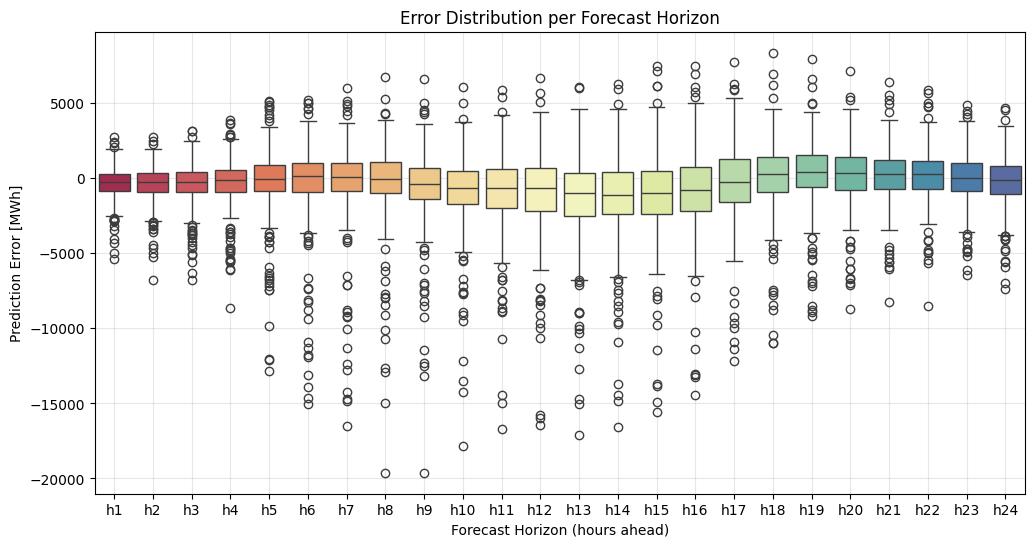

In [17]:
errors_df = pd.DataFrame({f"h{h}": errors_by_horizon[h] for h in range(1, 25)})

plt.figure(figsize=(12,6))
sns.boxplot(data=errors_df, palette="Spectral")
plt.title("Error Distribution per Forecast Horizon")
plt.xlabel("Forecast Horizon (hours ahead)")
plt.ylabel("Prediction Error [MWh]")
plt.grid(True, alpha=0.3)
plt.show()


**Key Findings – Error Distribution per Forecast Horizon**

- The **error variance increases from short- to mid-range forecast horizons**, indicating growing uncertainty as predictions extend further into the future.  
- **Short-term forecasts (1–4 hours ahead)** show narrow error distributions centered near zero, reflecting high accuracy and minimal bias.  
- **Mid-range horizons** exhibit wider spreads and more extreme outliers, suggesting increased volatility and occasional large deviations.  
- A slight **negative bias** (underestimation) is visible in the mid-range horizons, gradually shifting toward a more balanced error distribution at later steps.  
- Toward longer horizons, the error distributions become more stable again, highlighting the model’s ability to capture **recurring daily patterns**.

## Explainable AI: Feature Importance and SHAP Analysis

### 1. Feature Importance Analysis
This section aggregates and visualizes the feature importances from all 24 Random Forest models.
By averaging the importance scores across all forecast horizons, it identifies which variables consistently contribute the most to accurate predictions.
The resulting bar chart highlights the most influential temporal and historical features, providing insight into the key drivers of electricity load forecasting.

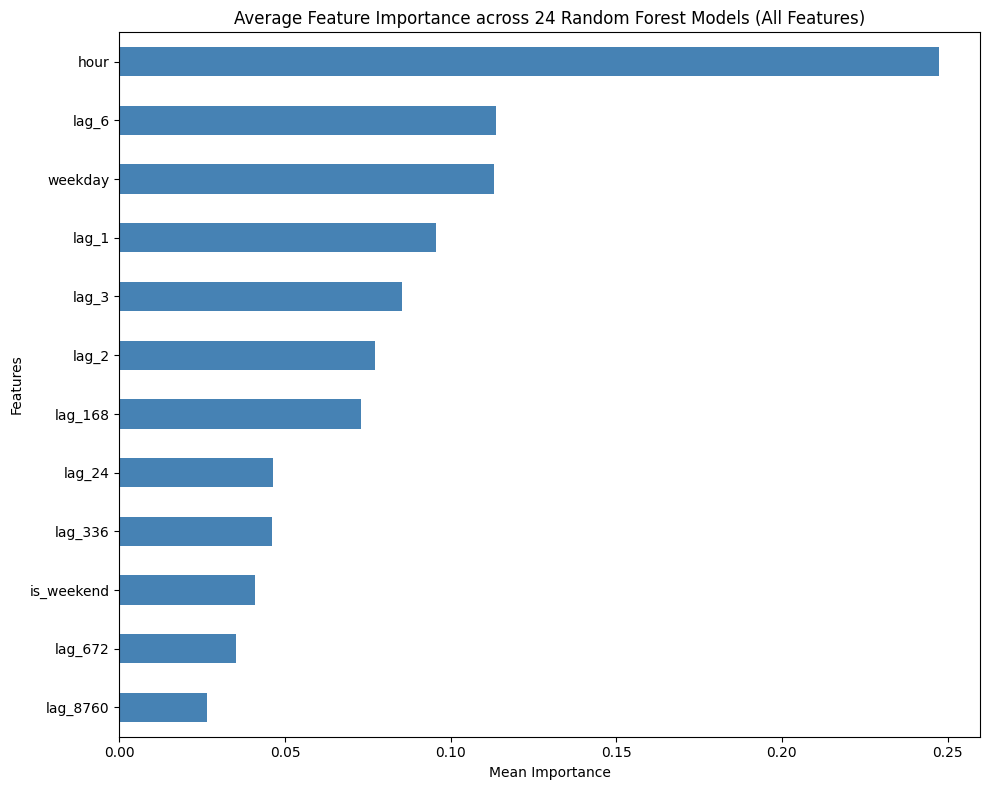

In [18]:
# Collect all feature importances from each model
importances_df = pd.DataFrame({
    h: models_24h[h].feature_importances_ for h in range(1, 25)
}, index=feature_cols)

# Compute mean importance across all forecast horizons
mean_importance = importances_df.mean(axis=1).sort_values(ascending=False)

# Plot all features
plt.figure(figsize=(10,8))
mean_importance.plot(kind="barh", color="steelblue")
plt.gca().invert_yaxis()
plt.title("Average Feature Importance across 24 Random Forest Models (All Features)")
plt.xlabel("Mean Importance")
plt.ylabel("Features")
plt.tight_layout()
plt.show()

**Key Findings – Feature Importance**

- The feature **`hour`** dominates the model, confirming that electricity load strongly follows **daily patterns** driven by human activity.  
- **`lag_6`** and **`weekday`** rank next, showing that both **recent consumption** and **day-of-week effects** significantly influence demand.  
- Short-term lags such as **`lag_1`**, **`lag_2`**, and **`lag_3`** contribute notably, emphasizing the importance of **immediate past load values**.  
- **`lag_24`** and **`lag_168`** (previous day and previous week) indicate that **daily and weekly cycles** also play a meaningful role.  
- Longer-term lags like **`lag_336`**, **`lag_672`**, and **`lag_8760`** have smaller effects, suggesting that the Random Forest relies primarily on **short- to mid-term temporal dependencies**.  
- Overall, the model effectively captures **seasonal and cyclical consumption patterns**, with the strongest influence coming from short-term and intraday features.  


### 2. Model Explainability with SHAP
This section applies SHAP (SHapley Additive exPlanations) to interpret the 1-hour-ahead Random Forest model.
By analyzing a representative test sample, SHAP quantifies each feature’s contribution to individual predictions.
The bar plot shows global feature importance based on average absolute SHAP values, while the beeswarm plot illustrates the direction and distribution of each feature’s effect on predicted load values.
Together, these plots enhance model transparency and confirm which features drive short-term electricity demand forecasts.

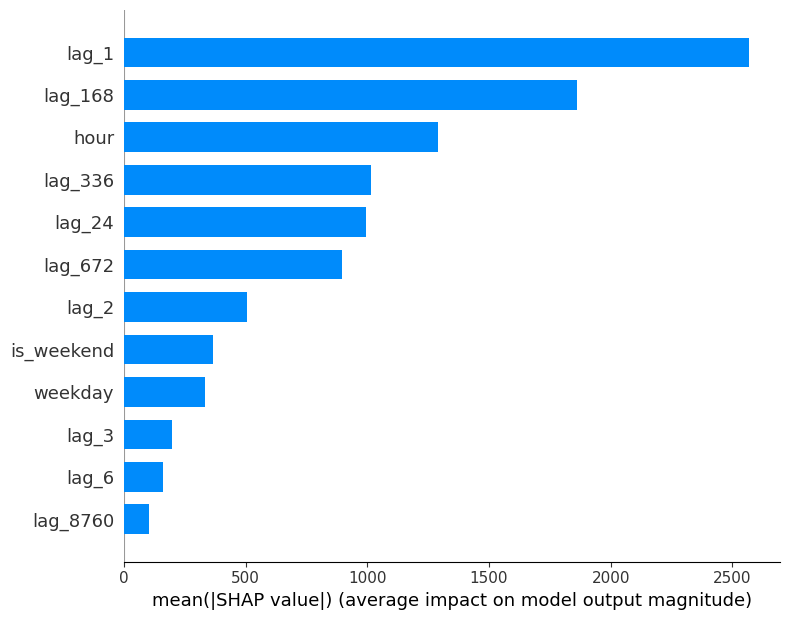

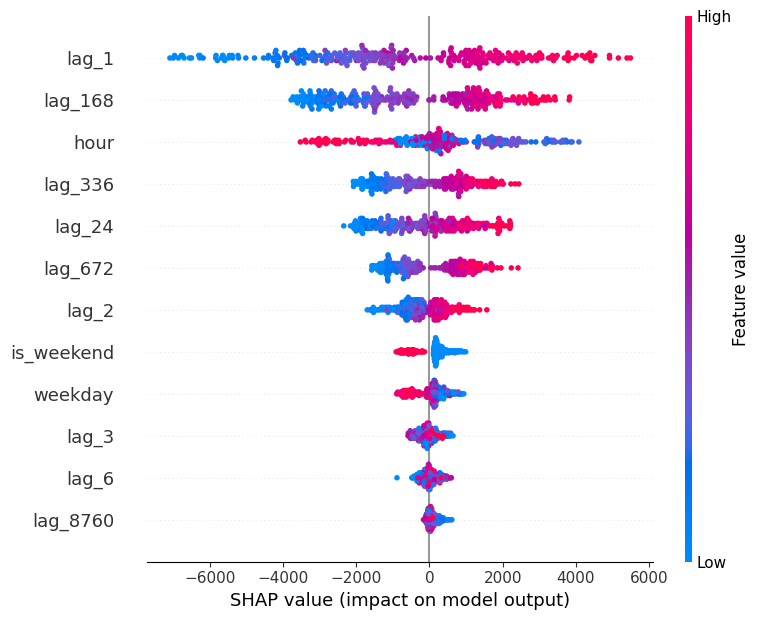

In [19]:
# Select one representative model, (the 1-hour ahead model)
model = models_24h[1]

# Use a smaller sample of test data for SHAP (to speed up computation)
X_sample = X_test.sample(300, random_state=42)

# Create SHAP explainer
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_sample)

# Global Feature Importance (mean absolute SHAP values)
shap.summary_plot(shap_values, X_sample, plot_type="bar", show=True)

# Detailed Distribution of Effects (beeswarm plot)
shap.summary_plot(shap_values, X_sample, show=True)


**Key Findings – SHAP Analysis**

- The SHAP results confirm that **recent load values** are the most influential predictors for short-term forecasts.  
- **`lag_1`** (previous hour) has the strongest impact, followed by **`lag_168`** (same hour one week earlier), highlighting the importance of both **short-term dependencies** and **weekly seasonality**.  
- The feature **`hour`** ranks next in importance, indicating that **intra-day patterns** also play a significant role in shaping electricity demand.  
- Medium-term lags such as **`lag_24`**, **`lag_336`**, and **`lag_672`** contribute moderately, reflecting the influence of **daily and multi-day cycles**.  
- Calendar features like **`is_weekend`** and **`weekday`** have smaller but consistent effects, capturing systematic differences between workdays and weekends.  
- The beeswarm plot shows largely **monotonic relationships** for lag-based features, where higher past load values tend to increase predictions, while lower values reduce the forecasted load, indicating an **intuitive and interpretable model behavior**.



### 3. Conclusion – Explainable AI for Random Forest

To interpret the Random Forest model and understand which features most strongly influenced its predictions, two complementary techniques were applied: **Feature Importance** and **SHAP (SHapley Additive Explanations)**.  
Together, they provide a transparent view of how the model captures temporal dependencies and recurring patterns in electricity consumption.

The feature importance analysis indicates that the model relies strongly on **time-of-day information (`hour`)** and **short-term lag features**, highlighting the importance of **intraday dynamics** and **recent load history**.  
Calendar-related variables such as `weekday` and `is_weekend` also contribute meaningfully, reflecting systematic differences between workdays and weekends.  
In addition, **daily and weekly lag features** (`lag_24`, `lag_168`) emphasize the relevance of **recurrent consumption cycles**, while longer-term lags (`lag_336`, `lag_672`, `lag_8760`) provide only a minor contribution, suggesting that long-term seasonal effects play a secondary role.

The SHAP analysis supports and refines these findings by offering a more detailed, instance-level perspective.  
It confirms that **recent load values**, particularly `lag_1`, exert the strongest influence on predictions, followed by **weekly seasonality (`lag_168`)** and **time-of-day effects (`hour`)**.  
Medium-term lags contribute moderately, and **calendar features** provide consistent contextual adjustments across predictions.  
The SHAP value distributions further show largely **monotonic relationships** for lag-based features, where higher past load values increase the predicted load, while lower values reduce it, demonstrating the model’s **intuitive and interpretable behavior**.

Overall, both explainability methods reveal that the Random Forest captures a **hierarchical temporal structure** of electricity demand — dominated by **short-term dynamics and weekly cycles**, with longer-term seasonal patterns playing a limited role.  
The strong agreement between global feature importance and local SHAP explanations confirms the **robustness and transparency** of the model’s decision process, establishing it as a reliable and explainable baseline for short-term load forecasting.


## Overall Conclusion

The Random Forest multi-horizon framework achieved strong short-term accuracy and stable medium-term performance.
The model effectively captured daily and weekly consumption patterns and demonstrated robust generalization on unseen test data.
Through explainable AI techniques (Feature Importance & SHAP), the model’s decision logic was interpretable and consistent with domain knowledge.